In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/debug_ipllr_renorm')
CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations', 'fc_ipllr_mnist.yaml')

In [3]:
import sys
sys.path.append(ROOT)

In [4]:
import os
from copy import deepcopy
import torch
import math
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, Subset, DataLoader
import torch.nn.functional as F

from utils.tools import read_yaml, set_random_seeds
from pytorch.configs.base import BaseConfig
from pytorch.configs.model import ModelConfig
from pytorch.models.abc_params.fully_connected.ipllr import FcIPLLR
from pytorch.models.abc_params.fully_connected.muP import FCmuP
from pytorch.models.abc_params.fully_connected.ntk import FCNTK
from pytorch.models.abc_params.fully_connected.standard_fc_ip import StandardFCIP
from utils.dataset.mnist import load_data
from utils.abc_params.debug_ipllr import *
from utils.plot.abc_parameterizations.debug_ipllr import *

### Load basic configuration and define variables 

In [5]:
N_TRIALS = 3
SEED = 30
L = 6
width = 1024
n_warmup_steps = 1
batch_size = 512
base_lr = 0.01
n_steps = 150
renorm_first = False
scale_first_lr = False

set_random_seeds(SEED)  # set random seed for reproducibility
config_dict = read_yaml(CONFIG_PATH)

In [6]:
config_dict = read_yaml(CONFIG_PATH)

input_size = config_dict['architecture']['input_size']

config_dict['architecture']['width'] = width
config_dict['architecture']['n_layers'] = L + 1
config_dict['optimizer']['params']['lr'] = base_lr
config_dict['activation']['name'] = 'gelu'
config_dict['scheduler'] = {'name': 'warmup_switch',
                            'params': {'n_warmup_steps': n_warmup_steps,
                                       'calibrate_base_lr': True,
                                       'default_calibration': False}}
        
base_model_config = ModelConfig(config_dict)

### Load data & define models

In [7]:
training_dataset, test_dataset = load_data(download=False, flatten=True)
train_data_loader = DataLoader(training_dataset, shuffle=True, batch_size=batch_size)
test_batches = list(DataLoader(test_dataset, shuffle=False, batch_size=batch_size))
batches = list(train_data_loader)
eval_batch = test_batches[0]

In [8]:
x,y = batches[0]
(x < 0).sum() / x.numel()

tensor(0.8309)

In [9]:
# RESET batches with opposite sign
# batches = [(-x, y) for (x, y) in batches]

In [10]:
x,y = batches[0]
(x < 0).sum() / x.numel()

tensor(0.8309)

In [11]:
config_dict['scheduler']['params']['calibrate_base_lr'] = False
config = ModelConfig(config_dict)

ipllrs = [FcIPLLR(config) for _ in range(N_TRIALS)]
#ipllrs_renorm = [FcIPLLR(config) for _ in range(N_TRIALS)]
#ipllrs_renorm_scale_lr = [FcIPLLR(config) for _ in range(N_TRIALS)]

config_dict['scheduler']['params']['calibrate_base_lr'] = True
config = ModelConfig(config_dict)
ipllrs_calib = [FcIPLLR(config, lr_calibration_batches=batches) for _ in range(N_TRIALS)]
ipllrs_calib_renorm = [FcIPLLR(config, lr_calibration_batches=batches) for _ in range(N_TRIALS)]
ipllrs_calib_renorm_scale_lr = [FcIPLLR(config, lr_calibration_batches=batches) for _ in range(N_TRIALS)]

initial base lr : [7.8500000000000005, 46.965911865234375, 230.82986450195312, 689.8438720703125, 737.0059204101562, 649.5567016601562, 145.51405334472656]
initial base lr : [7.8500000000000005, 46.15407180786133, 222.7506866455078, 654.6741333007812, 693.0280151367188, 896.6290283203125, 141.4002685546875]
initial base lr : [7.8500000000000005, 49.3372802734375, 297.0865478515625, 560.7622680664062, 680.9767456054688, 846.3974609375, 144.85125732421875]
initial base lr : [7.8500000000000005, 55.069759368896484, 396.2291259765625, 370.78948974609375, 725.1114501953125, 733.019287109375, 100.68914031982422]
initial base lr : [7.8500000000000005, 48.74224090576172, 214.1992645263672, 418.0809326171875, 485.0630187988281, 395.896728515625, 47.93536376953125]
initial base lr : [7.8500000000000005, 50.90858840942383, 325.6089782714844, 544.6148071289062, 1005.350830078125, 414.1053466796875, 104.7051773071289]
initial base lr : [7.8500000000000005, 52.17423629760742, 275.30023193359375, 582

In [12]:
for i in range(N_TRIALS):
    # copy params
    #ipllrs_renorm[i].copy_initial_params_from_model(ipllrs[i])
    #ipllrs_renorm_scale_lr[i].copy_initial_params_from_model(ipllrs[i])
    
    ipllrs_calib[i].copy_initial_params_from_model(ipllrs[i])
    ipllrs_calib_renorm[i].copy_initial_params_from_model(ipllrs[i])
    ipllrs_calib_renorm_scale_lr[i].copy_initial_params_from_model(ipllrs[i])
    
    # re-initialize
    #ipllrs_renorm[i].initialize_params()
    #ipllrs_renorm_scale_lr[i].initialize_params()
    
    ipllrs_calib[i].initialize_params()
    ipllrs_calib_renorm[i].initialize_params()
    ipllrs_calib_renorm_scale_lr[i].initialize_params()

In [13]:
# Make sure calibration takes into account normalization

for ipllr in ipllrs_calib:    
    initial_base_lrs = ipllr.scheduler.calibrate_base_lr(ipllr, batches=batches, normalize_first=False)
    ipllr.scheduler._set_param_group_lrs(initial_base_lrs)
    
for ipllr in ipllrs_calib_renorm:        
    initial_base_lrs = ipllr.scheduler.calibrate_base_lr(ipllr, batches=batches, normalize_first=True)
    ipllr.scheduler._set_param_group_lrs(initial_base_lrs)
    
for ipllr in ipllrs_calib_renorm_scale_lr:            
    initial_base_lrs = ipllr.scheduler.calibrate_base_lr(ipllr, batches=batches, normalize_first=True)
    ipllr.scheduler._set_param_group_lrs(initial_base_lrs)

initial base lr : [0.01, 0.028196392580866814, 0.9076456427574158, 5.850881576538086, 16.383840560913086, 28.035953521728516, 2.75435209274292]
initial base lr : [0.01, 0.02787650376558304, 0.9057221412658691, 6.7063889503479, 22.578495025634766, 19.862024307250977, 3.6487624645233154]
initial base lr : [0.01, 0.026966914534568787, 0.8043279647827148, 4.602268695831299, 13.32944393157959, 22.941225051879883, 3.3188157081604004]
initial base lr : [7.8500000000000005, 46.39674377441406, 305.0941162109375, 603.781005859375, 562.6358642578125, 616.2513427734375, 119.7124252319336]
initial base lr : [7.8500000000000005, 49.334415435791016, 309.4392395019531, 857.26904296875, 649.2785034179688, 1090.0927734375, 132.6603240966797]
initial base lr : [7.8500000000000005, 46.447479248046875, 236.2649383544922, 424.5413513183594, 618.1087646484375, 963.1669921875, 86.5775146484375]
initial base lr : [7.8500000000000005, 46.39674377441406, 305.0941162109375, 603.781005859375, 562.6358642578125, 61

In [14]:
# scale lr of first layer if needed

#for ipllr in ipllrs_renorm_scale_lr:
#    for i, param_group in enumerate(ipllr.optimizer.param_groups):
#        if i == 0:
#            param_group['lr'] = param_group['lr'] * (ipllr.d + 1)
#    ipllr.scheduler.warm_lrs[0] = ipllr.scheduler.warm_lrs[0] * (ipllr.d + 1)
    
for ipllr in ipllrs_calib_renorm_scale_lr:
    ipllr.scheduler.warm_lrs[0] = ipllr.scheduler.warm_lrs[0] * (ipllr.d + 1)

In [15]:
results = dict()

# without calibration
#results['ipllr'] = [collect_training_losses(ipllrs[i], batches, n_steps, normalize_first=False) 
#                    for i in range(N_TRIALS)]

#results['ipllr_renorm'] = [collect_training_losses(ipllrs_renorm[i], batches, n_steps, normalize_first=True)
#                           for i in range(N_TRIALS)]

#results['ipllr_renorm_scale_lr'] = [collect_training_losses(ipllrs_renorm_scale_lr[i], batches, n_steps, 
#                                                            normalize_first=True) 
#                                    for i in range(N_TRIALS)]

# with calibration
results['ipllr_calib'] = [collect_training_losses(ipllrs_calib[i], batches, n_steps, normalize_first=False)
                                 for i in range(N_TRIALS)]

results['ipllr_calib_renorm'] = [collect_training_losses(ipllrs_calib_renorm[i], batches, n_steps, 
                                                         normalize_first=True)
                                 for i in range(N_TRIALS)]

results['ipllr_calib_renorm_scale_lr'] = \
    [collect_training_losses(ipllrs_calib_renorm_scale_lr[i], batches, n_steps, normalize_first=True) 
     for i in range(N_TRIALS)]

# Training

In [16]:
mode = 'training'

In [17]:
losses = dict()
for key, res in results.items():
    losses[key] = [r[0] for r in res]
    
chis = dict()
for key, res in results.items():
    chis[key] = [r[1] for r in res]

## Losses and derivatives

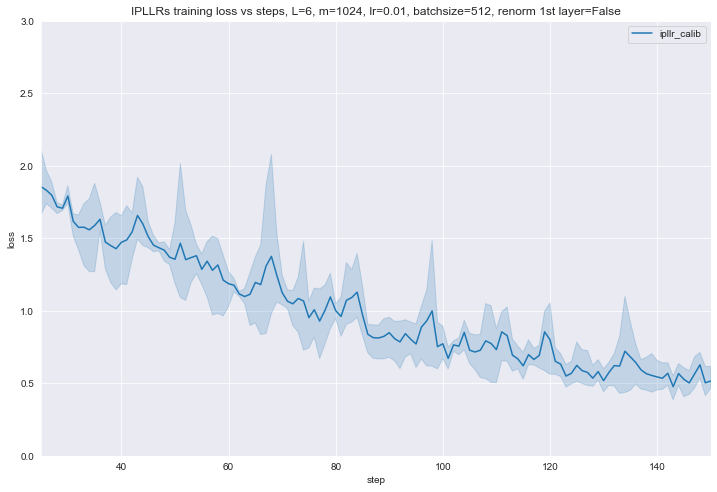

In [18]:
key = 'ipllr_calib'
los = {key: losses[key]}

key = 'loss'
plt.figure(figsize=(12, 8))
plot_losses_models(los, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode, 
                   normalize_first=renorm_first, marker=None, name='IPLLR')
#plt.savefig(
#    os.path.join(FIGURES_DIR, 'IPLLRs_1_last_small_{}_{}_L={}_m={}_lr={}_bs={}.png'.\
#                 format(mode, key, L, width, base_lr, batch_size, renorm_first, scale_first_lr)))
plt.xlim((25, 150))
plt.ylim((0, 3))
plt.show()

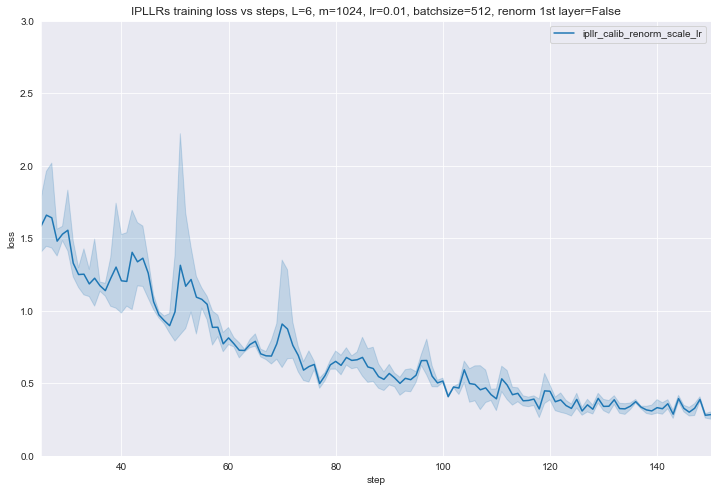

In [19]:
key = 'ipllr_calib_renorm_scale_lr'
los = {key: losses[key]}

key = 'loss'
plt.figure(figsize=(12, 8))
plot_losses_models(los, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode, 
                   normalize_first=renorm_first, marker=None, name='IPLLR')
#plt.savefig(
#    os.path.join(FIGURES_DIR, 'IPLLRs_1_last_small_{}_{}_L={}_m={}_lr={}_bs={}.png'.\
#                 format(mode, key, L, width, base_lr, batch_size, renorm_first, scale_first_lr)))
plt.xlim((25, 150))
plt.ylim((0, 3))
plt.show()

In [20]:
key = 'ipllr_calib_renorm'
los = {key: losses[key]}

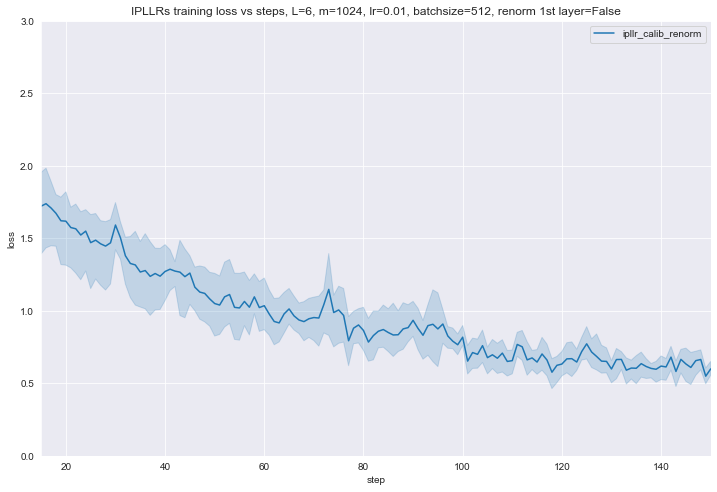

In [21]:
key = 'loss'
plt.figure(figsize=(12, 8))
plot_losses_models(los, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode, 
                   normalize_first=renorm_first, marker=None, name='IPLLR')
#plt.savefig(
#    os.path.join(FIGURES_DIR, 'IPLLRs_1_last_small_{}_{}_L={}_m={}_lr={}_bs={}.png'.\
#                 format(mode, key, L, width, base_lr, batch_size, renorm_first, scale_first_lr)))
plt.xlim((15, 150))
plt.ylim((0, 3))
plt.show()

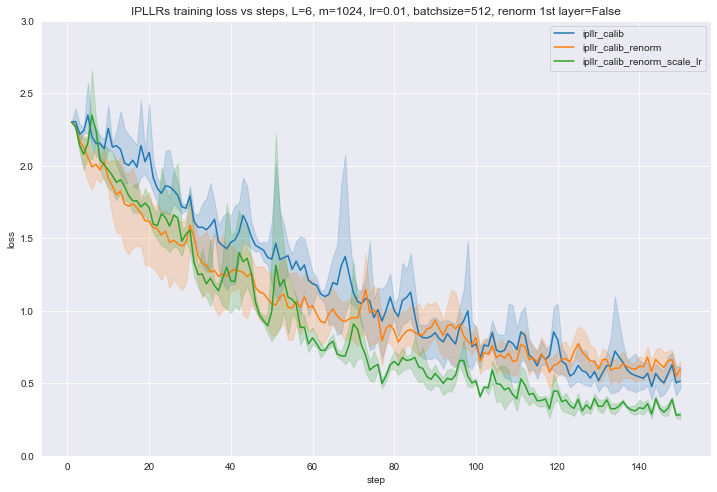

In [22]:
key = 'loss'
plt.figure(figsize=(12, 8))
plot_losses_models(losses, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode, 
                   normalize_first=renorm_first, marker=None, name='IPLLR')
#plt.savefig(
#    os.path.join(FIGURES_DIR, 'IPLLRs_1_last_small_{}_{}_L={}_m={}_lr={}_bs={}.png'.\
#                 format(mode, key, L, width, base_lr, batch_size, renorm_first, scale_first_lr)))
plt.ylim(0,3)
plt.show()

In [25]:
[ls[-1] for ls in losses['ipllr_calib_renorm_scale_lr']]

[0.30254197120666504, 0.25280898809432983, 0.2965596318244934]

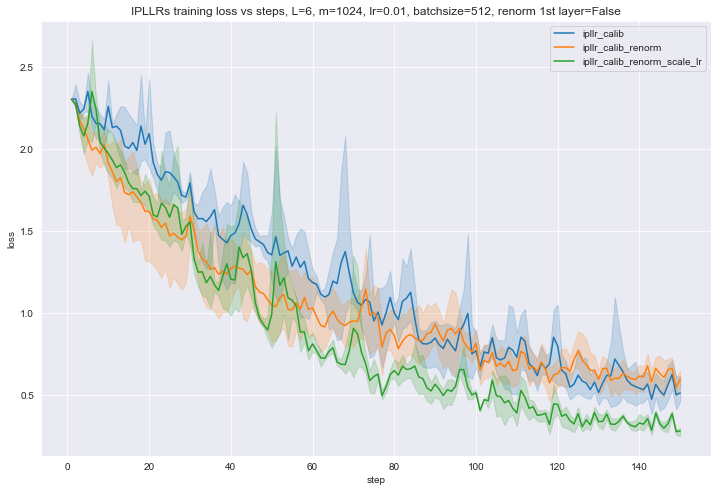

In [23]:
key = 'loss'
plt.figure(figsize=(12, 8))
plot_losses_models(losses, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode, 
                   normalize_first=renorm_first, marker=None, name='IPLLR')
#plt.savefig(
#    os.path.join(FIGURES_DIR, 'IPLLRs_1_last_small_{}_{}_L={}_m={}_lr={}_bs={}.png'.\
#                 format(mode, key, L, width, base_lr, batch_size, renorm_first, scale_first_lr)))
plt.show()

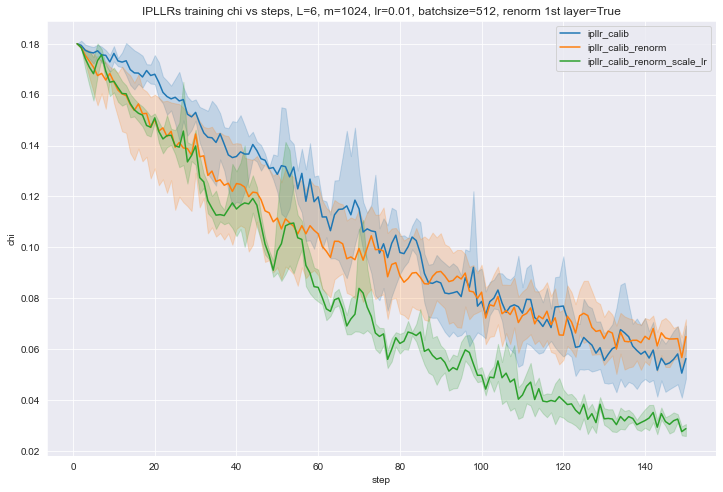

In [24]:
key = 'chi'
plt.figure(figsize=(12, 8))
plot_losses_models(chis, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode, marker=None,
                   name='IPLLR')
#plt.savefig(os.path.join(FIGURES_DIR, 'IPLLRs_1_last_small_{}_{}_L={}_m={}_lr={}_bs={}.png'.\
#                         format(mode, key, L, width, base_lr, batch_size)))
plt.show()